In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import os
import os.path
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import mltools as ml
from PIL import Image

from pprint import pprint

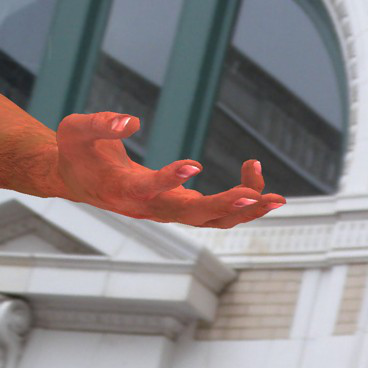

In [5]:
cur_img = Image.open('hand_labels_synth/synth2/00000001.jpg')
cur_img

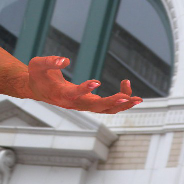

In [6]:
downscale = cur_img.resize((184,184))
downscale

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# ================================================================== #
#                  Input pipeline for custom dataset                 #
# ================================================================== #

img_size = 368, 368
lbl_size = 21, 3

# You should build your custom dataset as below.
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self):
        # TODO
        # Initialize file paths 
        self.paths = ['hand_labels_synth/synth2/', 'hand_labels_synth/synth3/']
        
        # Initialize a list of file names. 
        self.imgs = np.chararray(5591, itemsize=37)
        
        # Initialize images RGB pixels to calculate mean/std
        # 5591 images (TODO: Count how many jpg's there are to avoid
        #                    hard-coded values)
        # 368*368 = 135424 pixels
        # 3 channels for RGB
        pixels = torch.zeros(5591,3,368,368)

        # Initialize images' RGB means
#         sum_pixels = torch.zeros(3,368,368)
        
        # Initialize images' RGB std
#         stds = torch.zeros(3,368,368)
        
        # Initialize images' labels
        self.labels = torch.zeros(5591,21,3)
                           
            
        inpath2 = self.paths[0]   
        # Used to pick up where synth2 left off before all
        # 5591 images
        cutoff = 0
        for i,f in enumerate(sorted(os.listdir(inpath2))):
            # Since every iteration can be a .jpg or a .json
            # index to add to is floor(i/2)
            index = int(np.floor(i/2))
            
            if f.endswith('.jpg'):
                self.imgs[index] = inpath2+f
                cur_img = Image.open(self.imgs[index])
                # Transposed to be able to index each channel easier
                cur_img_px = torch.transpose(torch.Tensor(cur_img.getdata()), 0, 1)
                cur_img_px = cur_img_px.view(3,368,368)
                pixels[index] = cur_img_px
#                 sum_pixels += pixels 
#                 stds += pixels
                cur_img.close()
                
#                 print("Image: ", self.imgs[index].decode('utf-8', "ignore"))
#                 print("Pixels: ", list(self.pixels[index].shape))
#                 print("Mean: ", means[index])
#                 print("Std: ", stds[index])

            else:
                with open(inpath2+f, 'r') as fid:
                    dat = json.load(fid)
                self.labels[index] = torch.Tensor(dat['hand_pts'])
# #                 print("Labels: ", list(self.labels[index].shape))
# #                 print("_____________________________")
            cutoff = i
    
    
        print("-----Synth 2 Loaded------")
        
        
        inpath3 = self.paths[1]
        cutoff = int((cutoff+1)/2)
        for i,f in enumerate(sorted(os.listdir(inpath3))):
            index = int(np.floor(i/2))
            
            if f.endswith('.jpg'):
                self.imgs[index] = inpath3+f
                cur_img = Image.open(self.imgs[index])
                cur_img_px = torch.transpose(torch.Tensor(cur_img.getdata()), 0, 1)
                cur_img_px = cur_img_px.view(3,368,368)
                pixels[index] = cur_img_px
#                 sum_pixels += pixels 
#                 stds += pixels
                cur_img.close()
                
#                 print("Image: ", self.imgs[index].decode('utf-8', "ignore"))
#                 print("Pixels: ", list(self.pixels[index].shape))
#                 print("Mean: ", means[index])
#                 print("Std: ", stds[index])

            else:
                with open(inpath3+f, 'r') as fid:
                    dat = json.load(fid)
                self.labels[index] = torch.Tensor(dat['hand_pts'])
# #                 print("Labels: ", list(self.labels[index].shape))
# #                 print("_____________________________")


        print("-----Synth 3 Loaded------")
    
        # The total mean of all images per channel
        self.mean_channels = torch.mean(pixels, dim=0)
        self.std_channels = torch.std(pixels, dim=0)
        print("Mean Shape: ", self.mean_channels.shape)
        print("Mean: ", self.mean_channels)
        print("Std Shape: ", self.std_channels.shape)
        print("Std: ", self.std_channels)
                
    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        img = Image.open(self.imgs[index])
        # 2. Preprocess the data (e.g. torchvision.Transform).
        rgb_flat = torch.transpose(torch.Tensor(img.getdata()), 0, 1)
        rgb_image = rgb_flat.view(3,368,368)
        img_norm = TF.normalize(rgb_image, mean=self.mean_channels, std=self.std_channels)
#         img.close()
        # 3. Return a data pair (e.g. image and label).
        return (img_norm, self.labels[index])

    def __len__(self):
        # You should change 0 to the total size of your dataset.
        return len(self.imgs)

# You can then use the prebuilt data loader. 
custom_dataset = CustomDataset()
train_loader = torch.utils.data.DataLoader(dataset=custom_dataset,
                                           batch_size=64, 
                                           shuffle=True)

-----Synth 2 Loaded------
-----Synth 3 Loaded------
Mean Shape:  torch.Size([3, 368, 368])
Mean:  tensor([[[87.2999, 87.6553, 87.7798,  ..., 85.9090, 85.8403, 85.5756],
         [87.9599, 88.3591, 88.4802,  ..., 86.5037, 86.4781, 86.2202],
         [88.2876, 88.6510, 88.7398,  ..., 86.7407, 86.7194, 86.4527],
         ...,
         [89.3656, 89.6856, 89.8101,  ..., 88.1028, 88.0098, 87.8109],
         [89.3461, 89.6358, 89.7351,  ..., 87.9624, 87.8360, 87.6806],
         [89.1052, 89.3590, 89.4457,  ..., 87.6759, 87.5180, 87.3593]],

        [[89.6917, 89.9852, 90.0120,  ..., 87.6557, 87.6659, 87.4631],
         [90.2765, 90.6144, 90.6503,  ..., 88.2084, 88.2597, 88.0563],
         [90.4795, 90.8033, 90.8077,  ..., 88.3667, 88.4212, 88.2112],
         ...,
         [90.6537, 90.9259, 90.9725,  ..., 88.9539, 88.9299, 88.7711],
         [90.7224, 90.9683, 90.9893,  ..., 88.8950, 88.8515, 88.7396],
         [90.5266, 90.7394, 90.7498,  ..., 88.6614, 88.5935, 88.4772]],

        [[85.3813,

In [10]:
custom_dataset[0][0][0].mean()

tensor(1.0045)

In [8]:
custom_dataset[0][0][0].std()

tensor(0.2735)

In [9]:
# ================================================================== #
#                  Input pipeline for custom dataset                 #
# ================================================================== #

img_size = 368, 368
lbl_size = 21, 3

# You should build your custom dataset as below.
class CustomDataset2(torch.utils.data.Dataset):
    def __init__(self):
        # TODO
        # Initialize file paths 
        self.paths = ['hand_labels_synth/synth2/', 'hand_labels_synth/synth3/']
        
        # Initialize a list of file names. 
        self.imgs = np.chararray(5591, itemsize=37)
        
        # Initialize images RGB pixels to calculate mean/std
        # 5591 images (TODO: Count how many jpg's there are to avoid
        #                    hard-coded values)
        # 368*368 = 135424 pixels
        # 3 channels for RGB
        pixels = torch.zeros(5591,3,368,368)

        # Initialize images' RGB means
#         sum_pixels = torch.zeros(3,368,368)
        
        # Initialize images' RGB std
#         stds = torch.zeros(3,368,368)
        
        # Initialize images' labels
        self.labels = torch.zeros(5591,21,3)
                           
            
        inpath2 = self.paths[0]   
        # Used to pick up where synth2 left off before all
        # 5591 images
        cutoff = 0
        for i,f in enumerate(sorted(os.listdir(inpath2))):
            # Since every iteration can be a .jpg or a .json
            # index to add to is floor(i/2)
            index = int(np.floor(i/2))
            
            if f.endswith('.jpg'):
                self.imgs[index] = inpath2+f
                cur_img = Image.open(self.imgs[index])
                # Transposed to be able to index each channel easier
                cur_img_px = torch.transpose(torch.Tensor(cur_img.getdata()), 0, 1)
                cur_img_px = cur_img_px.view(3,368,368)
                pixels[index] = cur_img_px
#                 sum_pixels += pixels 
#                 stds += pixels
                cur_img.close()
                
#                 print("Image: ", self.imgs[index].decode('utf-8', "ignore"))
#                 print("Pixels: ", list(self.pixels[index].shape))
#                 print("Mean: ", means[index])
#                 print("Std: ", stds[index])

            else:
                with open(inpath2+f, 'r') as fid:
                    dat = json.load(fid)
                self.labels[index] = torch.Tensor(dat['hand_pts'])
# #                 print("Labels: ", list(self.labels[index].shape))
# #                 print("_____________________________")
            cutoff = i
    
    
        print("-----Synth 2 Loaded------")
        
        
        inpath3 = self.paths[1]
        cutoff = int((cutoff+1)/2)
        for i,f in enumerate(sorted(os.listdir(inpath3))):
            index = int(np.floor(i/2))
            
            if f.endswith('.jpg'):
                self.imgs[index] = inpath3+f
                cur_img = Image.open(self.imgs[index])
                cur_img_px = torch.transpose(torch.Tensor(cur_img.getdata()), 0, 1)
                cur_img_px = cur_img_px.view(3,368,368)
                pixels[index] = cur_img_px
#                 sum_pixels += pixels 
#                 stds += pixels
                cur_img.close()
                
#                 print("Image: ", self.imgs[index].decode('utf-8', "ignore"))
#                 print("Pixels: ", list(self.pixels[index].shape))
#                 print("Mean: ", means[index])
#                 print("Std: ", stds[index])

            else:
                with open(inpath3+f, 'r') as fid:
                    dat = json.load(fid)
                self.labels[index] = torch.Tensor(dat['hand_pts'])
# #                 print("Labels: ", list(self.labels[index].shape))
# #                 print("_____________________________")


        print("-----Synth 3 Loaded------")
    
        # The total mean of all images per channel
        self.mean_channels = torch.mean(pixels, dim=0)
        self.std_channels = torch.std(pixels, dim=0)
        print("Mean Shape: ", self.mean_channels.shape)
        print("Mean: ", self.mean_channels)
        print("Std Shape: ", self.std_channels.shape)
        print("Std: ", self.std_channels)
                
    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        img = Image.open(self.imgs[index])
        # 2. Preprocess the data (e.g. torchvision.Transform).
        rgb_flat = torch.transpose(torch.Tensor(img.getdata()), 0, 1)
        rgb_image = rgb_flat.view(3,368,368)
        rgb_image -= self.mean_channels
        rgb_image /= self.std_channels
#         img.close()
        # 3. Return a data pair (e.g. image and label).
        return (rgb_image, self.labels[index])

    def __len__(self):
        # You should change 0 to the total size of your dataset.
        return len(self.imgs)

# You can then use the prebuilt data loader. 
custom_dataset2 = CustomDataset2()
train_loader = torch.utils.data.DataLoader(dataset=custom_dataset2,
                                           batch_size=64, 
                                           shuffle=True)        
    


-----Synth 2 Loaded------
-----Synth 3 Loaded------
Mean Shape:  torch.Size([3, 368, 368])
Mean:  tensor([[[87.2999, 87.6553, 87.7798,  ..., 85.9090, 85.8403, 85.5756],
         [87.9599, 88.3591, 88.4802,  ..., 86.5037, 86.4781, 86.2202],
         [88.2876, 88.6510, 88.7398,  ..., 86.7407, 86.7194, 86.4527],
         ...,
         [89.3656, 89.6856, 89.8101,  ..., 88.1028, 88.0098, 87.8109],
         [89.3461, 89.6358, 89.7351,  ..., 87.9624, 87.8360, 87.6806],
         [89.1052, 89.3590, 89.4457,  ..., 87.6759, 87.5180, 87.3593]],

        [[89.6917, 89.9852, 90.0120,  ..., 87.6557, 87.6659, 87.4631],
         [90.2765, 90.6144, 90.6503,  ..., 88.2084, 88.2597, 88.0563],
         [90.4795, 90.8033, 90.8077,  ..., 88.3667, 88.4212, 88.2112],
         ...,
         [90.6537, 90.9259, 90.9725,  ..., 88.9539, 88.9299, 88.7711],
         [90.7224, 90.9683, 90.9893,  ..., 88.8950, 88.8515, 88.7396],
         [90.5266, 90.7394, 90.7498,  ..., 88.6614, 88.5935, 88.4772]],

        [[85.3813,

In [12]:
custom_dataset2[0][0][0].mean()

tensor(1.0045)

In [11]:
custom_dataset2[0][0][0].std()

tensor(0.2735)

In [20]:
edges = [[0,1],[1,2],[2,3],[3,4],[0,5],[5,6],[6,7],[7,8],[0,9],[9,10],[10,11],[11,12],[0,13],[13,14],[14,15],[15,16],[0,17],[17,18],[18,19],[19,20]]


paths = ['synth1/', 'synth2/', 'synth3/', 'synth4/']
paths = ['hand_labels_synth/synth2/', 'hand_labels_synth/synth3/']
inpath2 = paths[0]
inpath3 = paths[1]

# files contain the 00000001.json - 00003243.json files sorted
files2 = sorted([f for f in os.listdir(inpath2) if f.endswith('.jpg')])
files3 = sorted([f for f in os.listdir(inpath3) if f.endswith('.jpg')])

In [21]:
img = mpimg.imread(inpath+files2[0])

In [22]:
print(len(img), 'x', len(img[0]))

368 x 368


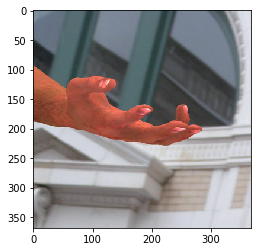

In [23]:
plt.imshow(img)

In [25]:
imgs2 = [mpimg.imread(inpath2+f) for f in files2]
imgs3 = [mpimg.imread(inpath3+f) for f in files3]

In [124]:
for i in range(10):
    print(custom_dataset.imgs[i])
    print(custom_dataset.labels[i])
    print("____________________________")

b'hand_labels_synth/synth2/00000001.jpg'
[[ 85.21452332 173.12060547   1.        ]
 [ 87.69029236 148.85780334   1.        ]
 [ 76.8404541  130.85449219   1.        ]
 [101.13573456 125.7907486    1.        ]
 [137.0382843  128.00276184   1.        ]
 [118.5532608  184.532547     1.        ]
 [142.43692017 187.96066284   1.        ]
 [167.59210205 178.79924011   1.        ]
 [196.06517029 162.23907471   1.        ]
 [147.82598877 200.03800964   1.        ]
 [191.43353271 212.16567993   1.        ]
 [223.47140503 205.14064026   1.        ]
 [254.28117371 192.29589844   1.        ]
 [171.59661865 207.18063354   1.        ]
 [219.74983215 217.37692261   1.        ]
 [250.63174438 209.32655334   1.        ]
 [280.5866394  197.31211853   1.        ]
 [189.62809753 210.22674561   1.        ]
 [232.78018188 204.87371826   1.        ]
 [252.85021973 186.22302246   1.        ]
 [249.9256134  160.24780273   1.        ]]
____________________________
b'hand_labels_synth/synth2/00000002.jpg'
[[104.

 [208.09584045 188.74313354   1.        ]]
____________________________
b'hand_labels_synth/synth2/00000010.jpg'
[[171.57324219 194.48181152   1.        ]
 [136.93972778 219.90545654   1.        ]
 [ 75.77993774 221.85853577   1.        ]
 [ 97.15272522 215.02442932   1.        ]
 [140.30342102 207.85397339   1.        ]
 [130.74980164 165.53787231   1.        ]
 [125.67121887 166.67961121   1.        ]
 [142.46551514 196.65644836   1.        ]
 [156.40223694 219.73135376   1.        ]
 [173.19244385 149.28369141   1.        ]
 [156.27859497 131.23539734   1.        ]
 [169.4841156  174.26591492   1.        ]
 [183.21821594 213.962677     1.        ]
 [208.44238281 143.3265686    1.        ]
 [260.03485107 180.92060852   1.        ]
 [271.00283813 219.13642883   1.        ]
 [252.51722717 237.87709045   1.        ]
 [240.98780823 142.81137085   1.        ]
 [258.59002686 144.9002533    1.        ]
 [265.27999878 167.92721558   1.        ]
 [255.03981018 200.6900177    1.        ]]
____

In [4]:
custom_dataset[0][0][0]

tensor([123., 123., 123.,  ..., 212., 210., 210.])

In [16]:
test = Image.open('hand_labels_synth/synth2/00000003.jpg')

In [7]:
img_tens = transforms.ToTensor()

In [8]:
img = img_tens(test)

In [15]:
img[0][0]*255

tensor([164., 164., 164., 164., 164., 164., 164., 164., 164., 165., 165., 166.,
        166., 166., 166., 166., 165., 165., 165., 165., 166., 166., 166., 166.,
        166., 168., 168., 169., 169., 169., 169., 169., 169., 169., 169., 169.,
        169., 169., 169., 169., 170., 170., 169., 169., 169., 169., 169., 169.,
        167., 166., 165., 165., 165., 165., 164., 164., 165., 166., 166., 166.,
        166., 166., 166., 166., 166., 166., 166., 166., 166., 166., 166., 166.,
        166., 166., 166., 166., 166., 166., 166., 166., 167., 167., 167., 167.,
        167., 167., 167., 167., 166., 166., 167., 167., 167., 167., 166., 166.,
        166., 166., 166., 166., 166., 166., 167., 167., 167., 167., 167., 167.,
        167., 167., 167., 167., 168., 169., 169., 169., 169., 168., 167., 167.,
        167., 167., 166., 166., 166., 166., 166., 166., 166., 166., 165., 165.,
        165., 165., 164., 164., 165., 164., 164., 166., 166., 165., 166., 167.,
        167., 167., 167., 167., 167., 16

In [15]:
pixels_pyt = torch.transpose(torch.Tensor(test.getdata()), 0, 1)

In [19]:
pixels_pyt = pixels_pyt.view(3,368,368)

In [30]:
pixels_R = torch.Tensor(test.getdata(0))

In [31]:
pixels_R[:368]

tensor([164., 164., 164., 164., 164., 164., 164., 164., 164., 165., 165., 166.,
        166., 166., 166., 166., 165., 165., 165., 165., 166., 166., 166., 166.,
        166., 168., 168., 169., 169., 169., 169., 169., 169., 169., 169., 169.,
        169., 169., 169., 169., 170., 170., 169., 169., 169., 169., 169., 169.,
        167., 166., 165., 165., 165., 165., 164., 164., 165., 166., 166., 166.,
        166., 166., 166., 166., 166., 166., 166., 166., 166., 166., 166., 166.,
        166., 166., 166., 166., 166., 166., 166., 166., 167., 167., 167., 167.,
        167., 167., 167., 167., 166., 166., 167., 167., 167., 167., 166., 166.,
        166., 166., 166., 166., 166., 166., 167., 167., 167., 167., 167., 167.,
        167., 167., 167., 167., 168., 169., 169., 169., 169., 168., 167., 167.,
        167., 167., 166., 166., 166., 166., 166., 166., 166., 166., 165., 165.,
        165., 165., 164., 164., 165., 164., 164., 166., 166., 165., 166., 167.,
        167., 167., 167., 167., 167., 16

In [32]:
pixels_R2 = pixels_R.view(368,368)

In [36]:
if torch.all(torch.eq(pixels_R[:368], pixels_R2[0])):
    print("yes")

yes


In [26]:
if pixels_pyt[0] == pixels_R:
    print("Yes")
else:
    print("No")

RuntimeError: bool value of Tensor with more than one value is ambiguous

In [17]:
pixels_pyt = torch.Tensor(test.getdata())

In [18]:
pixels_pyt.shape

torch.Size([135424, 3])

In [106]:
avg_pyt = pixels_pyt.mean(dim=1)

In [107]:
avg_pyt

tensor([169.0108, 163.1679, 154.7177])

In [103]:
pixels_pyt[0][:]

tensor([164., 174., 163.])

In [83]:
avg_pyt2 = pixels_pyt[1].mean()

In [84]:
avg_pyt2

tensor(163.1422)

In [82]:
pixels_pyt

tensor([[164., 164., 164.,  ..., 173., 173., 173.],
        [174., 174., 174.,  ..., 183., 183., 183.],
        [163., 163., 163.,  ..., 174., 174., 174.]])

In [65]:
test.thumbnail((1,1))

In [49]:
avg = test.getpixel((0,0))

In [50]:
np.mean(avg)

159.0

In [ ]:
custom_dataset[3]

In [17]:
xyz = torchvision.datasets.ImageFolder('hand_labels_synth/', transforms.Normalize(150,40))

In [18]:
xyz[0]

TypeError: tensor is not a torch image.

In [47]:
y = np.chararray(3, itemsize=37)

In [50]:
y[0] = 'hand_labels_synth/synth2/00000002.jpg'.encode('utf-8')

In [51]:
y[0]

b'hand_labels_synth/synth2/00000002.jpg'

In [52]:
y

chararray([b'hand_labels_synth/synth2/00000002.jpg', '', ''], dtype='|S37')

In [55]:
test = Image.open('hand_labels_synth/synth2/00000002.jpg')

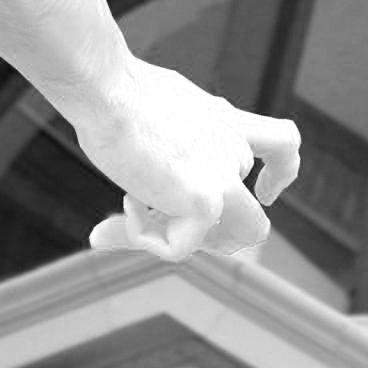

In [56]:
test.getchannel(0)

In [63]:
list(test.getdata(0))[:10]

[173, 172, 171, 171, 173, 173, 171, 169, 171, 171]

In [65]:
test.getextrema()

((8, 255), (14, 242), (4, 253))

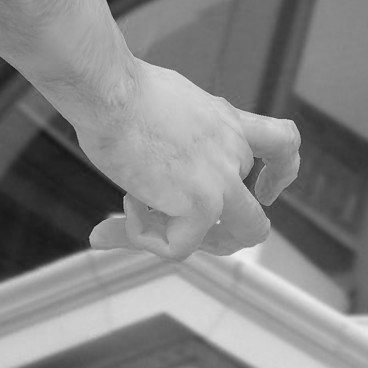

In [57]:
test.getchannel(1)

In [68]:
len(list(test.getdata(1)))

135424

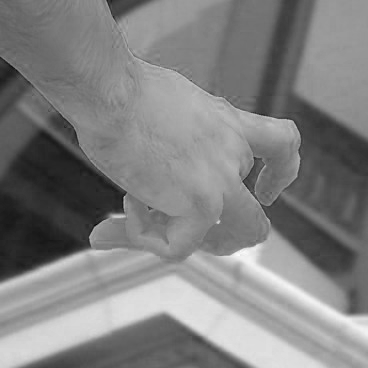

In [58]:
test.getchannel(2)

In [70]:
x = np.random.rand(10,3,5,5)
print(x)

[[[[0.9648088  0.05709243 0.92793206 0.26824686 0.48057187]
   [0.95120126 0.43220328 0.05977706 0.36434073 0.87764996]
   [0.98379028 0.62221659 0.70274797 0.95041072 0.61272719]
   [0.46153802 0.11113255 0.40861071 0.25367224 0.16147814]
   [0.74468108 0.41430727 0.07257616 0.70434945 0.5507269 ]]

  [[0.80266983 0.84377116 0.96467525 0.42821848 0.2623264 ]
   [0.92146763 0.76795984 0.5259411  0.61540254 0.859629  ]
   [0.64739816 0.65269956 0.1600775  0.86908959 0.87207854]
   [0.07750449 0.01726592 0.87822514 0.06020708 0.49129889]
   [0.42841295 0.54272383 0.7804696  0.74964732 0.80602968]]

  [[0.69647678 0.07361665 0.59378825 0.78613067 0.72515967]
   [0.54659109 0.25920384 0.57939042 0.49268974 0.13963763]
   [0.92239341 0.1035593  0.4472801  0.84263407 0.05472348]
   [0.44599018 0.87760108 0.38802484 0.71923927 0.88104872]
   [0.17406855 0.71543184 0.44110646 0.8850873  0.21427386]]]


 [[[0.70771375 0.84101688 0.92224003 0.48078329 0.28120733]
   [0.73040739 0.11192358 0.0426

   [0.22866185 0.00659542 0.70393794 0.98617657 0.08393019]]]]


In [72]:
np.mean((np.mean(x, axis=0)), axis=0)

array([[0.48493021, 0.51815499, 0.45483135, 0.42162473, 0.54765772],
       [0.54238805, 0.40884503, 0.49381065, 0.46130086, 0.51580474],
       [0.54243991, 0.53100838, 0.52492763, 0.53883519, 0.53685949],
       [0.51206031, 0.51110845, 0.5780928 , 0.45306578, 0.53804716],
       [0.48188111, 0.48362693, 0.50154702, 0.46840012, 0.48932703]])

In [60]:
x -= np.mean(x, axis=0)

In [61]:
x

array([[[-0.21112597, -0.15443933],
        [ 0.44042661,  0.05073408],
        [-0.32248293, -0.21910503]],

       [[-0.32722791, -0.0529118 ],
        [ 0.15418845,  0.05928811],
        [ 0.28084017, -0.34011714]],

       [[ 0.2356672 ,  0.36936049],
        [ 0.06588811,  0.36613803],
        [-0.30632838,  0.12778297]],

       [[ 0.11741244, -0.30932389],
        [-0.15561427,  0.34968278],
        [-0.16434306,  0.08842033]],

       [[ 0.43754459, -0.41187899],
        [ 0.24735023,  0.36121104],
        [ 0.08609029, -0.39754719]],

       [[-0.26264654,  0.26781767],
        [-0.21380957,  0.05777955],
        [-0.12585554,  0.27958354]],

       [[-0.39579469,  0.08445018],
        [-0.23602806, -0.31995585],
        [ 0.44766259,  0.54282613]],

       [[ 0.5428839 ,  0.10519816],
        [-0.12558167,  0.08305846],
        [ 0.27674948, -0.02178301]],

       [[-0.09346535,  0.32228036],
        [-0.35668226, -0.40864712],
        [ 0.01589023, -0.39299192]],

       [[-

In [24]:
np.std(x,axis=0)

array([[1., 1.],
       [1., 1.],
       [1., 1.]])

In [22]:
x

array([[[ 1.41425026,  0.39302995],
        [-0.97060026, -0.98602059],
        [ 0.44681772,  1.19057459]],

       [[ 1.29616665,  1.17649408],
        [-1.20505914, -0.07799141],
        [ 2.03296628, -0.79144658]],

       [[ 1.49102703,  1.27556899],
        [ 0.55613817, -1.3089799 ],
        [-1.15672149, -1.40442931]],

       [[-0.40622208,  0.58050292],
        [ 0.40863178, -1.11987739],
        [-0.11070391, -0.62461016]],

       [[-0.95904481,  0.65458735],
        [-0.30812586,  0.27642804],
        [ 0.62298306, -0.77224663]],

       [[ 0.30535888, -0.30514521],
        [ 1.2887618 , -0.10786404],
        [-1.00028209,  1.5368659 ]],

       [[-0.24850279, -0.40507512],
        [ 1.69950977,  1.31294302],
        [-0.15756831,  1.47474124]],

       [[-1.0298383 , -0.28327305],
        [ 0.57521918, -0.12305196],
        [-0.67082792, -0.6541421 ]],

       [[-0.75754109, -2.23889305],
        [-1.20181916,  2.05443979],
        [-1.11094392,  0.14784738]],

       [[-

In [23]:
np.std(x)

0.9999999999999999

In [54]:
# 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
img = Image.open('hand_labels_synth/synth2/00000002.jpg')
# 2. Preprocess the data (e.g. torchvision.Transform).
rgb_flat = torch.transpose(torch.Tensor(img.getdata()), 0, 1)
RGB_IMAGE = rgb_flat.view(3,368,368)
RGB_IMAGE -= RGB_IMAGE.mean(dim=0)
RGB_IMAGE /= RGB_IMAGE.std(dim=0)

In [55]:
RGB_IMAGE

tensor([[[ 1.1073,  1.1073,  1.1073,  ..., -0.8836, -0.8836, -0.8836],
         [ 1.1073,  1.1073,  1.1073,  ..., -0.8836, -0.8836, -0.8836],
         [ 1.1073,  1.1073,  1.1073,  ..., -0.8836, -0.8836, -0.8836],
         ...,
         [-0.9684, -0.9684, -0.9684,  ..., -0.1325, -0.0949, -0.0949],
         [-0.9684, -0.9684, -0.9684,  ..., -0.1325, -0.0949, -0.0949],
         [-0.9684, -0.9684, -0.9684,  ..., -0.1325, -0.0949, -0.0949]],

        [[-0.2701, -0.2701, -0.2701,  ..., -0.2020, -0.2020, -0.2020],
         [-0.2701, -0.2701, -0.2701,  ..., -0.2020, -0.2020, -0.2020],
         [-0.2701, -0.2701, -0.2701,  ..., -0.2020, -0.2020, -0.2020],
         ...,
         [-0.0605, -0.0605, -0.0605,  ..., -0.9272, -0.9492, -0.9492],
         [-0.0605, -0.0605, -0.0605,  ..., -0.9272, -0.9492, -0.9492],
         [-0.0605, -0.0605, -0.0605,  ..., -0.9272, -0.9492, -0.9492]],

        [[-0.8372, -0.8372, -0.8372,  ...,  1.0856,  1.0856,  1.0856],
         [-0.8372, -0.8372, -0.8372,  ...,  1

In [56]:
# 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
img = Image.open('hand_labels_synth/synth2/00000002.jpg')
# 2. Preprocess the data (e.g. torchvision.Transform).
rgb_flat = torch.transpose(torch.Tensor(img.getdata()), 0, 1)
RGB_IMAGE = rgb_flat.view(3,368,368)
RGB_NORM = TF.normalize(RGB_IMAGE, mean=RGB_IMAGE.mean(dim=0), std=RGB_IMAGE.std(dim=0))

In [57]:
RGB_NORM

tensor([[[ 1.1073,  1.1073,  1.1073,  ..., -0.8836, -0.8836, -0.8836],
         [ 1.2693,  1.2693,  1.2153,  ..., -0.8836, -0.8836, -0.8836],
         [ 1.3774,  1.4044,  1.3774,  ..., -0.8836, -0.8836, -0.8836],
         ...,
         [ 1.8095,  1.8095,  1.8095,  ...,  2.2974,  2.3731,  2.4488],
         [ 1.7555,  1.7825,  1.7825,  ...,  2.2216,  2.2974,  2.3731],
         [ 1.7285,  1.7555,  1.7555,  ...,  2.2216,  2.2974,  2.2974]],

        [[-0.4321, -0.4321, -0.3781,  ..., -0.2020, -0.2020, -0.2020],
         [-0.2701, -0.2701, -0.2701,  ..., -0.2020, -0.2020, -0.2020],
         [-0.1620, -0.1350, -0.1080,  ..., -0.2020, -0.2020, -0.2020],
         ...,
         [ 1.7825,  1.7825,  1.8365,  ...,  2.1459,  2.1459,  2.2216],
         [ 1.7285,  1.7555,  1.8095,  ...,  2.0702,  2.0702,  2.1459],
         [ 1.7015,  1.7285,  1.7825,  ...,  2.0702,  2.0702,  2.0702]],

        [[-1.1073, -1.1343, -1.1073,  ...,  1.0856,  1.0856,  1.0856],
         [-0.9453, -0.9723, -0.9993,  ...,  1

In [69]:
RGB_IMAGE.shape

torch.Size([3, 368, 368])